In [1]:
from timeit import default_timer as timer
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import datetime
from enum import Enum
import os

In [2]:
class WeightInitMethod(Enum):
    ALL_ONES = "Alles auf 1"
    UNIFORM = "Gleichmäßige Verteilung"
    NORMAL = "Normalverteilung"

USING_COLAB = False
EPOCHS = 25
BATCH_SIZE = 128
ACTIVATION_FN = nn.Tanh
LOSS_FN = nn.CrossEntropyLoss
LEARN_RATE = 1e-2
WEIGHT_INIT_METHOD = WeightInitMethod.UNIFORM


In [3]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    x = torch.ones(1, device=device)

    return device

In [4]:
device = get_device()
#device = 'cpu' # CUDA ist langsamer als CPU
print(f"device: {device}")

# Umschalten zwischen Colab oder lokaler Installation
if USING_COLAB:
    from google.colab import drive
    from google.colab.patches import cv2_imshow

    drive.mount("/content/drive")

device: cuda


Download and load the training data


In [5]:
def get_data(batch_size: int = 32) -> Tuple[DataLoader, DataLoader]:
    transform = transforms.Compose(
        [
            # Converts to float and normalizes from [0, 255] to [0, 1]
            transforms.ToTensor(),
            # Flattens the 2D image 28x28 to 1D vector 784
            transforms.Lambda(lambda x: x.view(-1)),
        ]
    )

    train_set = datasets.MNIST("data/", download=True, train=True, transform=transform)
    test_set = datasets.MNIST("data/", download=True, train=False, transform=transform)

    train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

    return train_dl, test_dl

Modell (KNN) definieren mit beliebig vielen Schichten, die jeweils variable Anzahl Neuronen beinhalten. Wir beginnen hier immer mit 28x28 Eingabe-Neuronen und müssen am Ende immer auf 10 Ausgabe-Neuronen kommen


In [6]:
def get_model() -> tuple[nn.Module, nn.Module, SGD]:
    model = nn.Sequential(
        nn.Linear(28 * 28, 50),
        ACTIVATION_FN(),
        nn.Linear(50, 40),
        ACTIVATION_FN(),
        nn.Linear(40, 30),
        ACTIVATION_FN(),
        nn.Linear(30, 20),
        ACTIVATION_FN(),
        nn.Linear(20, 10),
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=LEARN_RATE)

    return model, loss_fn, optimizer

In [7]:
def init_weights(m: nn.Module):
    if type(m) == nn.Linear:
        if WEIGHT_INIT_METHOD == WeightInitMethod.ALL_ONES:
            m.weight.data.fill_(1)
        elif WEIGHT_INIT_METHOD == WeightInitMethod.UNIFORM:
            m.weight.data.uniform_(-0.1, 0.1)
        elif WEIGHT_INIT_METHOD == WeightInitMethod.NORMAL:
            m.weight.data.normal_(0.0, 0.1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [8]:
def train_batch(
    x: torch.Tensor, y: torch.Tensor, model: nn.Module, opt: SGD, loss_fn: nn.Module
) -> float:
    model.train()

    prediction = model(x)
    # print(f"prediction.shape {prediction.shape}")

    batch_loss = loss_fn(prediction, y)
    # print(f"batch_loss {batch_loss}")

    batch_loss.backward()
    opt.step()
    opt.zero_grad()

    return batch_loss.item()

In [9]:
def accuracy(x: torch.Tensor, y: torch.Tensor, model: nn.Module):
    model.eval()
    with torch.no_grad():
        prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

In [10]:
def loss(x: torch.Tensor, y: torch.Tensor, model: nn.Module, loss_fn: nn.Module):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
        loss = loss_fn(prediction, y)

    return loss.item()

In [11]:
train_dl, test_dl = get_data(BATCH_SIZE)
model, loss_fn, optimizer = get_model()

In [12]:
# ----------------------------------------------
# Training >>>
#
print("Starting training...")

# Hier werden die initialen Gewichte des Netzes zufällig gesetzt
model.apply(init_weights)

epochs = 25

arrPlotX = []
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in tqdm(range(epochs)):
    timeBeginEpoch = timer()
    train_epoch_losses, train_epoch_accuracies = [], []

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        # print(f"x.shape: {x.shape}  y.shape: {y.shape}\n")

        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)

    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device)

        val_is_correct = accuracy(x, y, model)
        validation_loss = loss(x, y, model, loss_fn)

    val_epoch_accuracy = np.mean(val_is_correct)
    arrPlotX.append(epoch)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    test_losses.append(validation_loss)
    test_accuracies.append(val_epoch_accuracy)
    timeEndEpoch = timer()
    print(
        f"epoch: {epoch}, train_acc: {100 * train_epoch_accuracy:.2f}%, test_acc: {100 * val_epoch_accuracy:.2f}%, took {timeEndEpoch-timeBeginEpoch:.1f}s"
    )

Starting training...


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:11<04:42, 11.78s/it]

epoch: 0, train_acc: 11.99%, test_acc: 11.35%, took 11.8s


  8%|▊         | 2/25 [00:22<04:11, 10.95s/it]

epoch: 1, train_acc: 11.24%, test_acc: 11.35%, took 10.4s


 12%|█▏        | 3/25 [00:31<03:47, 10.34s/it]

epoch: 2, train_acc: 11.24%, test_acc: 11.35%, took 9.6s


 16%|█▌        | 4/25 [00:41<03:33, 10.18s/it]

epoch: 3, train_acc: 14.26%, test_acc: 26.45%, took 9.9s


 20%|██        | 5/25 [00:51<03:20, 10.02s/it]

epoch: 4, train_acc: 31.28%, test_acc: 28.03%, took 9.7s


 24%|██▍       | 6/25 [01:01<03:08,  9.94s/it]

epoch: 5, train_acc: 31.61%, test_acc: 36.11%, took 9.8s


 28%|██▊       | 7/25 [01:11<02:59,  9.97s/it]

epoch: 6, train_acc: 37.51%, test_acc: 40.32%, took 10.0s


 32%|███▏      | 8/25 [01:20<02:48,  9.89s/it]

epoch: 7, train_acc: 45.70%, test_acc: 50.28%, took 9.7s


 36%|███▌      | 9/25 [01:30<02:37,  9.84s/it]

epoch: 8, train_acc: 56.34%, test_acc: 60.42%, took 9.7s


 40%|████      | 10/25 [01:40<02:26,  9.79s/it]

epoch: 9, train_acc: 65.00%, test_acc: 68.10%, took 9.7s


 44%|████▍     | 11/25 [01:50<02:17,  9.79s/it]

epoch: 10, train_acc: 70.44%, test_acc: 72.08%, took 9.8s


 48%|████▊     | 12/25 [02:00<02:07,  9.81s/it]

epoch: 11, train_acc: 74.23%, test_acc: 76.11%, took 9.9s


 52%|█████▏    | 13/25 [02:10<01:58,  9.87s/it]

epoch: 12, train_acc: 77.61%, test_acc: 79.58%, took 10.0s


 56%|█████▌    | 14/25 [02:20<01:49,  9.98s/it]

epoch: 13, train_acc: 80.56%, test_acc: 82.12%, took 10.2s


 60%|██████    | 15/25 [02:30<01:39,  9.99s/it]

epoch: 14, train_acc: 83.13%, test_acc: 84.15%, took 10.0s


 64%|██████▍   | 16/25 [02:40<01:29,  9.97s/it]

epoch: 15, train_acc: 85.20%, test_acc: 86.13%, took 9.9s


 68%|██████▊   | 17/25 [02:50<01:19,  9.92s/it]

epoch: 16, train_acc: 87.14%, test_acc: 87.52%, took 9.8s


 72%|███████▏  | 18/25 [03:00<01:10, 10.04s/it]

epoch: 17, train_acc: 88.77%, test_acc: 88.94%, took 10.3s


 76%|███████▌  | 19/25 [03:10<01:01, 10.22s/it]

epoch: 18, train_acc: 90.03%, test_acc: 89.82%, took 10.6s


 80%|████████  | 20/25 [03:22<00:52, 10.47s/it]

epoch: 19, train_acc: 90.99%, test_acc: 90.81%, took 11.0s


 84%|████████▍ | 21/25 [03:32<00:42, 10.60s/it]

epoch: 20, train_acc: 91.72%, test_acc: 91.56%, took 10.9s


 88%|████████▊ | 22/25 [03:42<00:31, 10.39s/it]

epoch: 21, train_acc: 92.38%, test_acc: 91.81%, took 9.9s


 92%|█████████▏| 23/25 [03:52<00:20, 10.21s/it]

epoch: 22, train_acc: 92.88%, test_acc: 92.41%, took 9.8s


 96%|█████████▌| 24/25 [04:02<00:10, 10.10s/it]

epoch: 23, train_acc: 93.25%, test_acc: 92.55%, took 9.9s


100%|██████████| 25/25 [04:12<00:00, 10.10s/it]

epoch: 24, train_acc: 93.56%, test_acc: 92.76%, took 10.1s


In [13]:
# Save with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_artifacts_dir = os.path.join("run_artifacts", timestamp)
os.makedirs(run_artifacts_dir, exist_ok=True)

if USING_COLAB:
    path = "/content/drive/My Drive/ColabNotebooks/MNIST_model.pt"
else:
    path = os.path.join(run_artifacts_dir, "MNIST_model.pt")

torch.save(model, path)

In [14]:
import json

# Save the accuracies and losses to a JSON file
results = {
    "settings": {
        "Epochen": epochs,
        "Batchgröße": BATCH_SIZE,
        "Aktivierungsfunktion": ACTIVATION_FN.__name__,
        "Fehlerfunktion": LOSS_FN.__name__,
        "Lernrate": LEARN_RATE,
        "Initialisierung der Gewichte": str(WEIGHT_INIT_METHOD.value),
    },
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accuracies": train_accuracies,
    "test_accuracies": test_accuracies,
}

with open(os.path.join(run_artifacts_dir, "training_results.json"), "w") as f:
    json.dump(results, f, indent=4, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

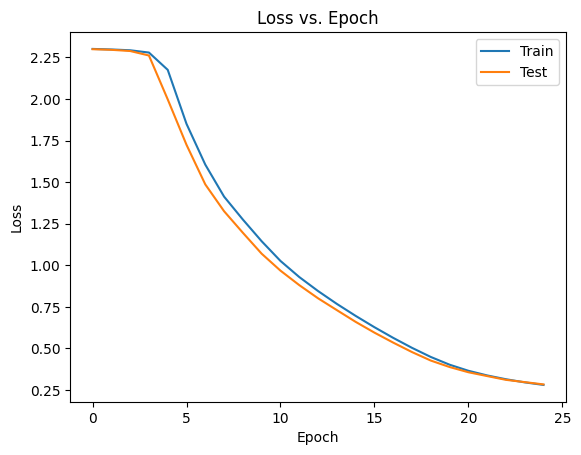

In [15]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"])

if USING_COLAB:
    plt.savefig("/content/drive/My Drive/ColabNotebooks/results/losses_exp0.png")
else:
    plt.savefig(os.path.join(run_artifacts_dir, "losses_exp.png"))